# Решение трека №1

* Участник: Мелентьев Никита
* Команда: 101-team

------------------------------

**Используемые файлы:**
* Папка ./data - с данными
* Папка ./results - с результатами
* Файл utils.py - код с вспомогательными функциями
* Файл main.ipynb - скрипт для обучения модели и расчета сабмита

## Imports

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool, cv

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')
import utils

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

## Data Load

**Target**

In [3]:
target_train_df = pd.read_csv('./data/target_train.csv')
sub_df = pd.read_csv('./data/sample_submission.csv')

print('Train shape:', target_train_df.shape[0])
print('Test shape:', sub_df.shape[0])

# Проверим что трейн / тест не пересекаются по id
assert len(set(sub_df.NPLV.unique()).intersection(target_train_df.NPLV.unique())) == 0

target_train_df.head(3)

Train shape: 2063
Test shape: 780


,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091


**Chronom**

In [4]:
chronom_train_df = pd.read_csv('./data/chronom_train.csv',index_col = 0)
chronom_test_df = pd.read_csv('./data/chronom_test.csv',index_col = 0)

# Типизация
chronom_train_df.VR_NACH = pd.to_datetime(chronom_train_df.VR_NACH)
chronom_test_df.VR_NACH = pd.to_datetime(chronom_test_df.VR_NACH)
chronom_train_df.VR_KON = pd.to_datetime(chronom_train_df.VR_KON)
chronom_test_df.VR_KON = pd.to_datetime(chronom_test_df.VR_KON)

# Уберем баг с 2011
chronom_train_df = chronom_train_df[chronom_train_df.VR_NACH.dt.year == 2021].copy()
chronom_test_df = chronom_test_df[chronom_test_df.VR_NACH.dt.year == 2021].copy()

# Закодируем марку
le = LabelEncoder()
chronom_train_df['NOP_le'] = le.fit_transform(chronom_train_df['NOP'])
le_dict = dict(zip(le.classes_, np.arange(len(le.classes_))))
chronom_test_df['NOP_le'] = chronom_test_df['NOP'].map(lambda x: le_dict.get(x, -1)).astype('int64')

chronom_train_df.head(3)

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,NOP_le
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN,33
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN,17
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN,8


**Produv**

In [6]:
produv_train_df = pd.read_csv('./data/produv_train.csv')
produv_test_df = pd.read_csv('./data/produv_test.csv')

# Типизация
produv_train_df.SEC = pd.to_datetime(produv_train_df.SEC)
produv_test_df.SEC = pd.to_datetime(produv_test_df.SEC)

# Сортировка
produv_train_df = produv_train_df.sort_values(['NPLV', 'SEC']).reset_index(drop = True)
produv_test_df = produv_test_df.sort_values(['NPLV', 'SEC']).reset_index(drop = True)

# Проверка совпадения id с train / test
assert len(set(produv_train_df.NPLV.unique()).intersection(target_train_df.NPLV.unique())) == target_train_df.NPLV.nunique()
assert produv_train_df.NPLV.nunique() == target_train_df.NPLV.nunique()
assert len(set(produv_test_df.NPLV.unique()).intersection(sub_df.NPLV.unique())) == sub_df.NPLV.nunique()
assert produv_test_df.NPLV.nunique() == sub_df.NPLV.nunique()

# Оставим только время продувки (на основе хронометража)
produv_train_df = produv_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV', 'VR_NACH', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
produv_test_df = produv_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_NACH', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
produv_train_df = produv_train_df[(produv_train_df.SEC >= produv_train_df.VR_NACH)&
               (produv_train_df.SEC <= produv_train_df.VR_KON)]\
    .drop(['VR_NACH', 'VR_KON'], 1)
produv_test_df = produv_test_df[(produv_test_df.SEC >= produv_test_df.VR_NACH)&
               (produv_test_df.SEC <= produv_test_df.VR_KON)]\
    .drop(['VR_NACH', 'VR_KON'], 1)

# расход в минуту -> расход в секунду
produv_train_df['RAS'] = produv_train_df['RAS'] / 60
produv_test_df['RAS'] = produv_test_df['RAS'] / 60
produv_train_df = utils.min_to_sec(produv_train_df)
produv_test_df = utils.min_to_sec(produv_test_df)

# новые признаки
produv_train_df['RAS_MUL_POL'] = produv_train_df['RAS'] * produv_train_df['POL']
produv_test_df['RAS_MUL_POL'] = produv_test_df['RAS'] * produv_test_df['POL']
produv_train_df['RAS_REL_POL'] = produv_train_df['RAS'] / produv_train_df['POL']
produv_test_df['RAS_REL_POL'] = produv_test_df['RAS'] / produv_test_df['POL']

produv_train_df.head(3)

,NPLV,SEC,RAS,POL,RAS_MUL_POL,RAS_REL_POL
0,510008.0,2021-01-01 03:18:26,6.366667,3.92,24.957333,1.62415
1,510008.0,2021-01-01 03:18:27,6.366667,3.92,24.957333,1.62415
2,510008.0,2021-01-01 03:18:28,6.366667,3.92,24.957333,1.62415


**Lom**

In [7]:
lom_train_df = pd.read_csv('./data/lom_train.csv')
lom_test_df = pd.read_csv('./data/lom_test.csv')

# Для категориальных фичей
lom_train_df['VDL'] = 'VDL_' + lom_train_df['VDL'].astype('str')
lom_test_df['VDL'] = 'VDL_' + lom_test_df['VDL'].astype('str')

# Проверка на совпадение id с трейн / тестом
assert len(set(lom_train_df.VDL.unique()).union(lom_test_df.VDL.unique())) == len(lom_train_df.VDL.unique())
assert lom_train_df[lom_train_df.duplicated(['NPLV', 'VDL'])].shape[0] == 0

lom_train_df.head(3)

,NPLV,VDL,NML,VES
0,510008,VDL_4,К,56500
1,510008,VDL_8,О,16700
2,510008,VDL_13,КП,3000


**Plavki info**

In [8]:
plavki_train_df = pd.read_csv('./data/plavki_train.csv')
plavki_test_df = pd.read_csv('./data/plavki_test.csv')

# Типизация
plavki_train_df['plavka_VR_NACH'] = pd.to_datetime(plavki_train_df['plavka_VR_NACH'])
plavki_train_df['plavka_VR_KON'] = pd.to_datetime(plavki_train_df['plavka_VR_KON'])
plavki_test_df['plavka_VR_NACH'] = pd.to_datetime(plavki_test_df['plavka_VR_NACH'])
plavki_test_df['plavka_VR_KON'] = pd.to_datetime(plavki_test_df['plavka_VR_KON'])

# Удаление багов с дуплями
plavki_train_df = plavki_train_df[~plavki_train_df.duplicated(['NPLV'], keep = 'first')].reset_index(drop = True)
plavki_test_df = plavki_test_df[~plavki_test_df.duplicated(['NPLV'], keep = 'first')].reset_index(drop = True)

# Для категориальных фичей кодируем марку
le = LabelEncoder()
plavki_train_df['plavka_NMZ'] = le.fit_transform(plavki_train_df['plavka_NMZ'])
le_dict = dict(zip(le.classes_, np.arange(len(le.classes_))))
plavki_test_df['plavka_NMZ'] = plavki_test_df['plavka_NMZ'].map(lambda x: le_dict.get(x, -1))

plavki_train_df.head(3)

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,42,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,42,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,58,Изл,973,цилиндрическая,13,5 сопловая,13


**sip**

In [9]:
sip_train_df = pd.read_csv('./data/sip_train.csv')
sip_test_df = pd.read_csv('./data/sip_test.csv')

# Типизация
sip_train_df['DAT_OTD'] = pd.to_datetime(sip_train_df['DAT_OTD'])
sip_test_df['DAT_OTD'] = pd.to_datetime(sip_test_df['DAT_OTD'])

# Для категориальных фичей кодируем вид
sip_train_df['VDSYP'] = 'VDSYP_' + sip_train_df['VDSYP'].astype('str')
sip_test_df['VDSYP'] = 'VDSYP_' + sip_test_df['VDSYP'].astype('str')

# Оставим только время продувки (на основе хронометража)
sip_train_df = sip_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV','VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
sip_test_df = sip_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
sip_train_df = sip_train_df[sip_train_df['DAT_OTD'] <= sip_train_df['VR_KON']].copy()
sip_test_df = sip_test_df[sip_test_df['DAT_OTD'] <= sip_test_df['VR_KON']].copy()

sip_train_df.head(3)

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD,VR_KON
0,510008,VDSYP_346,Уголь ТО,570,2021-01-01 03:03:53,2021-01-01 03:37:55
1,510008,VDSYP_346,Уголь ТО,220,2021-01-01 03:04:10,2021-01-01 03:37:55
2,510008,VDSYP_408,изв_ЦОИ,7300,2021-01-01 03:08:17,2021-01-01 03:37:55


**chugun**

In [10]:
chugun_train_df = pd.read_csv('./data/chugun_train.csv')
chugun_test_df = pd.read_csv('./data/chugun_test.csv')

# Типизация
chugun_train_df['DATA_ZAMERA'] = pd.to_datetime(chugun_train_df['DATA_ZAMERA'])
chugun_test_df['DATA_ZAMERA'] = pd.to_datetime(chugun_test_df['DATA_ZAMERA'])

chugun_train_df.head(3)

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40


**gas**



In [251]:
gas_train_df = pd.read_csv('./data/gas_train.csv')
gas_test_df = pd.read_csv('./data/gas_test.csv')

# Типизация
gas_train_df['Time'] = pd.to_datetime(gas_train_df['Time'])
gas_test_df['Time'] = pd.to_datetime(gas_test_df['Time'])

# Оставим только время продувки (на основе хронометража)
gas_train_df = gas_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV','VR_NACH', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
gas_test_df = gas_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_NACH', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
gas_train_df = gas_train_df[gas_train_df['Time'] <= gas_train_df['VR_KON']].copy()
gas_test_df = gas_test_df[gas_test_df['Time'] <= gas_test_df['VR_KON']].copy()

# Новая фича
gas_train_df['T_rel'] = gas_train_df['T'] / gas_train_df['V'] 
gas_test_df['T_rel'] = gas_test_df['T'] / gas_test_df['V'] 
for col in ['O2', 'N2', 'H2', 'CO2', 'CO', 'AR']:
    gas_train_df[col + '_V'] = gas_train_df[col] / 100 * gas_train_df['V']
for col in ['O2', 'N2', 'H2', 'CO2', 'CO', 'AR']:
    gas_test_df[col + '_V'] = gas_test_df[col] / 100 * gas_train_df['V']

gas_train_df.head(3)

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure,VR_NACH,VR_KON,T_rel
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938,2021-01-01 03:18:25,2021-01-01 03:37:55,0.001204
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938,2021-01-01 03:18:25,2021-01-01 03:37:55,0.001204
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938,2021-01-01 03:18:25,2021-01-01 03:37:55,0.001201


In [262]:
# Суммарный вышедший объем по каждому газу от начала продувки и до конца продувки
gas_train_df[gas_train_df['Time'] >= gas_train_df['VR_NACH']]\
    .groupby(['NPLV'])[['O2_V', 'N2_V', 'H2_V', 'CO2_V', 'CO_V', 'AR_V']].sum()\
    .add_suffix('_SUM_PRODUVKA').reset_index()

,NPLV,O2_V_SUM_PRODUVKA,N2_V_SUM_PRODUVKA,H2_V_SUM_PRODUVKA,CO2_V_SUM_PRODUVKA,CO_V_SUM_PRODUVKA,AR_V_SUM_PRODUVKA
0,510008,1.574702e+06,1.078068e+08,1.611839e+06,5.020635e+07,8.776682e+07,1.592854e+06
1,510009,9.017420e+05,1.123420e+08,1.344425e+06,5.244179e+07,9.384074e+07,1.634301e+06
2,510010,6.608042e+05,1.125178e+08,1.792450e+06,5.361530e+07,8.840551e+07,1.718297e+06
3,510011,1.880053e+06,9.702999e+07,6.510494e+05,4.578040e+07,8.081543e+07,1.406818e+06
4,510012,1.309368e+06,1.157170e+08,2.667100e+06,5.526340e+07,8.672085e+07,1.658549e+06
...,...,...,...,...,...,...,...
2058,512318,6.214520e+05,6.441470e+07,5.178409e+06,4.437334e+07,9.688920e+07,1.083285e+06
2059,512319,9.880129e+05,6.836511e+07,4.675298e+06,4.243800e+07,1.012927e+08,1.123226e+06
2060,512320,8.920561e+05,6.495868e+07,5.053150e+06,3.964593e+07,9.503349e+07,1.098866e+06
2061,512321,6.752398e+05,7.989692e+07,4.722192e+06,4.855663e+07,9.278043e+07,1.279677e+06


In [ ]:
gas_train_df = gas_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV','VR_NACH', KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
gas_test_df = gas_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)

In [250]:
chronom_train_df

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,NOP_le
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN,33
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN,17
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN,8
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN,32
35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN,20
...,...,...,...,...,...,...,...
20943,512322,опер,Повалка,2021-04-26 18:31:26,2021-04-26 18:41:10,NaN,25
20944,512322,опер,Выпуск металла,2021-04-26 18:41:10,2021-04-26 18:47:40,NaN,1
20945,512322,опер,Отсечка шлака,2021-04-26 18:46:15,2021-04-26 18:46:15,NaN,18
20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN,28


In [234]:
# Температура чугуна к газу во время замера -> как изменялась температура газа до конца продувки от этого момента?
chugun_test_df_with_gas = chugun_test_df.assign(DATA_ZAMERA_MIN = chugun_test_df.DATA_ZAMERA.dt.round('min')).merge(
    gas_test_df.assign(DATA_ZAMERA_MIN = gas_test_df.Time.dt.round('min'))\
        [['NPLV', 'DATA_ZAMERA_MIN', 'T']].rename(columns = {'T':'T_GAS_ZAMER'}),
    on = ['NPLV', 'DATA_ZAMERA_MIN'], how = 'left'
).groupby(['NPLV', 'DATA_ZAMERA_MIN', 'T'], as_index = False)[['T_GAS_ZAMER']].mean()
chugun_test_df_with_gas['T_CHUGUN_REL_GAS'] = chugun_test_df_with_gas['T'] / chugun_test_df_with_gas['T_GAS_ZAMER']
chugun_test_df_with_gas

,NPLV,DATA_ZAMERA_MIN,T,T_GAS_ZAMER,T_CHUGUN_REL_GAS
0,512324,2021-05-05 17:23:00,1355.0,NaN,NaN
1,512327,2021-05-05 20:00:00,1390.0,NaN,NaN
2,512328,2021-05-05 22:29:00,1373.0,95.859863,14.322991
3,512331,2021-05-06 01:58:00,1383.0,NaN,NaN
4,512333,2021-05-06 05:27:00,1387.0,128.544062,10.790074
...,...,...,...,...,...
775,513369,2021-06-29 16:52:00,1324.0,NaN,NaN
776,513370,2021-06-29 17:36:00,1389.0,NaN,NaN
777,513371,2021-06-29 18:53:00,1332.0,NaN,NaN
778,513372,2021-06-29 19:42:00,1378.0,NaN,NaN


In [235]:
chugun_test_df_with_gas

,NPLV,DATA_ZAMERA_MIN,T,T_GAS_ZAMER,T_CHUGUN_REL_GAS
0,512324,2021-05-05 17:23:00,1355.0,NaN,NaN
1,512327,2021-05-05 20:00:00,1390.0,NaN,NaN
2,512328,2021-05-05 22:29:00,1373.0,95.859863,14.322991
3,512331,2021-05-06 01:58:00,1383.0,NaN,NaN
4,512333,2021-05-06 05:27:00,1387.0,128.544062,10.790074
...,...,...,...,...,...
775,513369,2021-06-29 16:52:00,1324.0,NaN,NaN
776,513370,2021-06-29 17:36:00,1389.0,NaN,NaN
777,513371,2021-06-29 18:53:00,1332.0,NaN,NaN
778,513372,2021-06-29 19:42:00,1378.0,NaN,NaN


In [237]:
gas_test_df[gas_test_df.NPLV == 512327]

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure,VR_KON,T_rel
3848,512327,2021-05-05 21:07:01.437,232637.859375,133.680557,10.26,79.269997,0.00,8.840000,0.54,1.09,26.110550,26.479674,16.138599,2021-05-05 21:36:27,0.000575
3849,512327,2021-05-05 21:07:02.437,234915.281250,133.680557,10.26,79.269997,0.00,8.840000,0.54,1.09,26.109938,26.479343,16.138599,2021-05-05 21:36:27,0.000569
3850,512327,2021-05-05 21:07:03.437,237755.703125,134.027771,10.26,79.269997,0.00,8.840000,0.54,1.09,26.109326,26.479011,16.138599,2021-05-05 21:36:27,0.000564
3851,512327,2021-05-05 21:07:04.437,239598.437500,134.027771,10.26,79.269997,0.00,8.840000,0.54,1.09,26.108714,26.478679,16.138599,2021-05-05 21:36:27,0.000559
3852,512327,2021-05-05 21:07:05.437,240562.609375,134.027771,10.26,79.269997,0.00,8.840000,0.54,1.09,26.108102,26.478348,16.138599,2021-05-05 21:36:27,0.000557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5593,512327,2021-05-05 21:36:22.437,231940.296875,824.305542,0.00,65.900002,0.11,27.049999,5.96,0.98,25.690671,40.263311,16.377316,2021-05-05 21:36:27,0.003554
5594,512327,2021-05-05 21:36:23.437,232438.750000,824.305542,0.00,65.900002,0.11,27.049999,5.96,0.98,25.691030,40.259695,16.355614,2021-05-05 21:36:27,0.003546
5595,512327,2021-05-05 21:36:24.437,233432.531250,823.611145,0.00,67.459999,0.09,26.559999,4.89,0.99,25.691389,40.256078,16.355614,2021-05-05 21:36:27,0.003528
5596,512327,2021-05-05 21:36:25.437,233828.828125,822.916687,0.00,67.459999,0.09,26.559999,4.89,0.99,25.691749,40.252461,16.348379,2021-05-05 21:36:27,0.003519


In [238]:
chugun_test_df[chugun_test_df.NPLV == 512327]

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
1,512327,266400.0,1390.0,0.3,0.33,0.032,0.099,0.01,0.0,0.0,0.05,0.024,2021-05-05 20:00:30


In [239]:
chronom_test_df[chronom_test_df.NPLV == 512327]

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,NOP_le
11,512327,межпл.прост.,межпл. простой,2021-05-05 21:02:29,2021-05-05 21:07:01,NaN,33
12,512327,межпл.прост.,Осмотр конвертера,2021-05-05 21:02:43,2021-05-05 21:05:54,NaN,17
13,512327,межпл.прост.,Слив шлака,2021-05-05 21:05:54,2021-05-05 21:07:07,NaN,32
14,512327,опер,Завалка лома,2021-05-05 21:07:01,2021-05-05 21:08:55,NaN,4
15,512327,опер,Заливка чугуна,2021-05-05 21:08:55,2021-05-05 21:18:33,NaN,5
16,512327,опер,Продувка,2021-05-05 21:18:33,2021-05-05 21:36:27,NaN,29


In [242]:
chronom_test_df[chronom_test_df.NPLV == 512324]

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,NOP_le
1,512324,межпл.прост.,межпл. простой,2021-05-05 17:35:55,2021-05-05 17:41:21,NaN,33
2,512324,межпл.прост.,Осмотр конвертера,2021-05-05 17:36:07,2021-05-05 17:39:07,NaN,17
3,512324,межпл.прост.,Слив шлака,2021-05-05 17:39:07,2021-05-05 17:41:20,NaN,32
4,512324,опер,Завалка лома,2021-05-05 17:41:21,2021-05-05 17:43:16,NaN,4
5,512324,опер,Нагрев лома,2021-05-05 17:43:16,2021-05-05 17:49:21,NaN,9
6,512324,опер,Нагрев лома,2021-05-05 17:43:16,2021-05-05 17:49:21,1452.0,9
7,512324,вн.пл.прост.,Наложение продувки,2021-05-05 17:54:20,2021-05-05 18:00:56,NaN,10
8,512324,опер,Заливка чугуна,2021-05-05 18:00:56,2021-05-05 18:03:19,NaN,5
9,512324,опер,Продувка,2021-05-05 18:03:19,2021-05-05 18:24:22,NaN,29


In [215]:
# nplv_start_with_temp_gas_df = chronom_train_df.assign(VR_NACH_MIN = chronom_train_df.VR_NACH.dt.round('min'))\
#     [chronom_train_df.NOP == 'Продувка'].merge(
#     gas_train_df.assign(VR_NACH_MIN = gas_train_df.Time.dt.round('min'))\
#         [['NPLV', 'VR_NACH_MIN', 'T']].rename(columns = {'T':'T_GAS_ZAMER_NACH_PRODUV'}),
#     on = ['NPLV', 'VR_NACH_MIN'], how = 'left'
# ).groupby(['NPLV', 'VR_NACH_MIN'], as_index = False)[['T_GAS_ZAMER_NACH_PRODUV']].mean()

In [225]:
# # to merge
# chugun_train_df_with_gas[['NPLV', 'T_GAS_ZAMER', 'T_CHUGUN_REL_GAS']]

In [220]:
nplv_start_with_temp_gas_df= nplv_start_with_temp_gas_df.merge(
    chugun_train_df_with_gas[['NPLV', 'T_GAS_ZAMER']], on = ['NPLV'], how = 'left', validate = '1:1'
)

In [224]:
nplv_start_with_temp_gas_df['T_GAS_DELTA_SINCE_ZAMER'] = nplv_start_with_temp_gas_df['T_GAS_ZAMER'] \
    - nplv_start_with_temp_gas_df['T_GAS_ZAMER_NACH_PRODUV']

# to merge
nplv_start_with_temp_gas_df[['NPLV', 'T_GAS_DELTA_SINCE_ZAMER']]

,NPLV,T_GAS_DELTA_SINCE_ZAMER
0,510008,-28.125000
1,510009,-116.168983
2,510010,-233.635453
3,510011,-19.313794
4,510012,-236.735032
...,...,...
2058,512318,NaN
2059,512319,-291.188514
2060,512320,NaN
2061,512321,NaN


## Features

In [354]:
# Какие фичи в целом собирать для данных
used_features = [
    
    # Суммы
    'VDL_SUM','VDSYP_SUM',
    
    # Фичи продувки
    'NPLV_SUM_RAS', 'NPLV_MEDIAN_RAS', 'NPLV_MEAN_RAS', 'NPLV_STD_RAS', 'NPLV_MIN_RAS', 'NPLV_MAX_RAS',
    'NPLV_SUM_POL', 'NPLV_MEDIAN_POL', 'NPLV_MEAN_POL', 'NPLV_STD_POL', 'NPLV_MIN_POL', 'NPLV_MAX_POL',
    'NPLV_MEAN_RAS_MUL_POL', 'NPLV_MEAN_RAS_REL_POL',
#     'NPLV_SUM_RAS_MUL_POL', 'NPLV_MEDIAN_RAS_MUL_POL', 'NPLV_MEAN_RAS_MUL_POL', 'NPLV_STD_RAS_MUL_POL', 'NPLV_MIN_RAS_MUL_POL', 'NPLV_MAX_RAS_MUL_POL',
#     'NPLV_SUM_RAS_REL_POL', 'NPLV_MEDIAN_RAS_REL_POL', 'NPLV_MEAN_RAS_REL_POL', 'NPLV_STD_RAS_REL_POL', 'NPLV_MIN_RAS_REL_POL', 'NPLV_MAX_RAS_REL_POL',
    'NPLV_total_seconds', 'NPLV_TIME_SINCE_LAST', 
    
    # Фичи плавки
    'plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL',
    'plavka_ST_FURM', 'plavka_ST_GOL', 'plavka_NMZ',
    
    # Фичи чугуна
    'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU', 'V', 'TI', 'CHUGUN_SINCE_ZAME_SECONDS', #'VES',#'T', #
    
    # Комбинированные фичи
#     'VES_CHUGUN_REL_LOM', 'VES_CHUGUN_SUM_LOM', 'VES_CHUGUN_REL_SIP','VES_CHUGUN_SUM_SIP', 'VES_CHUGUN_SUM_SIP_LOM',
#     'T_CHUGUN_REL_GAS', 'T_GAS_DELTA_SINCE_ZAMER', 
    
    # Фичи газа
    'T_last_gas',  'V_last_gas', 'O2_last_gas', 'N2_last_gas', 'H2_last_gas', 'CO2_last_gas', 'CO_last_gas', 'AR_last_gas',
    'O2_mean_gas', 'N2_mean_gas', 'H2_mean_gas', 'CO2_mean_gas', 'CO_mean_gas', 'AR_mean_gas', 'T фурмы 1_mean_gas', 'T фурмы 2_mean_gas', 'O2_pressure_mean_gas',
#     'V_sum_gas', 'T_rel_last_gas', 'T_mean_gas', 'T_rel_mean_gas', 'V_mean_gas',
#     'O2_V_SUM_PRODUVKA', 'N2_V_SUM_PRODUVKA', 'H2_V_SUM_PRODUVKA', 'CO2_V_SUM_PRODUVKA', 'CO_V_SUM_PRODUVKA', 'AR_V_SUM_PRODUVKA',
#     'MAIN_FURMA,
    
    # Другие фичи
    'PLAVKI_O2', 'TIME_FROM_PLAVKI_TO_PRODUV', #'TIME_FROM_START_TO_PRODUV', 'OPERATIONS_COUNT_TO_PRODUV'
    
    # Другие фичи
#     '0_CHRONO_NOP', '4_CHRONO_NOP', '5_CHRONO_NOP', '6_CHRONO_NOP', '7_CHRONO_NOP', '8_CHRONO_NOP', 
#     '9_CHRONO_NOP', '10_CHRONO_NOP', '11_CHRONO_NOP', '12_CHRONO_NOP', '13_CHRONO_NOP', '14_CHRONO_NOP', 
#     '16_CHRONO_NOP', '17_CHRONO_NOP', '19_CHRONO_NOP', '20_CHRONO_NOP', '21_CHRONO_NOP', '22_CHRONO_NOP', 
#     '24_CHRONO_NOP', '26_CHRONO_NOP', '27_CHRONO_NOP', '29_CHRONO_NOP', '30_CHRONO_NOP', '32_CHRONO_NOP', 
#     '33_CHRONO_NOP',
    
] + list(lom_train_df.VDL.unique())\
    + list(sip_train_df.VDSYP.unique()) # фичи лома / материалов
# [x + '_REL' for x in list(sip_train_df.VDSYP.unique())]

cat_features = ['plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL']
target_feature_1 = 'TST'
target_feature_2 = 'C'

**Соберем фичи**

In [355]:
# TRAIN
train_df = target_train_df.copy()
train_df = utils.prepare_features(train_df, produv_train_df, lom_train_df, 
                            plavki_train_df, sip_train_df, chugun_train_df, 
                            gas_train_df, chronom_train_df, used_features)\
    [used_features + ['NPLV', target_feature_1, target_feature_2]]
assert train_df.shape[0] == target_train_df.shape[0]

# TEST
test_df = sub_df.copy()
test_df = utils.prepare_features(test_df, produv_test_df, lom_test_df, 
                           plavki_test_df, sip_test_df, chugun_test_df, 
                           gas_test_df, chronom_test_df, used_features)\
    [used_features + ['NPLV', target_feature_1, target_feature_2]]
assert test_df.shape[0] == sub_df.shape[0]

train_df.head()

,VDL_SUM,VDSYP_SUM,NPLV_SUM_RAS,NPLV_MEDIAN_RAS,NPLV_MEAN_RAS,NPLV_STD_RAS,NPLV_MIN_RAS,NPLV_MAX_RAS,NPLV_SUM_POL,NPLV_MEDIAN_POL,NPLV_MEAN_POL,NPLV_STD_POL,NPLV_MIN_POL,NPLV_MAX_POL,NPLV_MEAN_RAS_MUL_POL,NPLV_MEAN_RAS_REL_POL,NPLV_total_seconds,NPLV_TIME_SINCE_LAST,plavka_NAPR_ZAD,plavka_TIPE_FUR,plavka_TIPE_GOL,plavka_ST_FURM,plavka_ST_GOL,plavka_NMZ,SI,MN,S,P,CR,NI,CU,V,TI,CHUGUN_SINCE_ZAME_SECONDS,T_last_gas,V_last_gas,O2_last_gas,N2_last_gas,H2_last_gas,CO2_last_gas,CO_last_gas,AR_last_gas,O2_mean_gas,N2_mean_gas,H2_mean_gas,CO2_mean_gas,CO_mean_gas,AR_mean_gas,T фурмы 1_mean_gas,T фурмы 2_mean_gas,O2_pressure_mean_gas,PLAVKI_O2,TIME_FROM_PLAVKI_TO_PRODUV,VDL_4,VDL_8,VDL_13,VDL_23,VDL_61,VDL_20,VDL_48,VDL_49,VDL_63,VDL_3,VDSYP_346,VDSYP_408,VDSYP_171,VDSYP_442,VDSYP_104,VDSYP_119,VDSYP_397,NPLV,TST,C
0,76200.0,20970.0,16240.172271,13.840876,13.892363,1.676171,1.233333,16.083333,1335.281393,0.861364,1.142242,0.773493,0.77,7.070000,15.316885,14.785282,1168.0,NaN,2,1,1,11,11,42,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,203.0,788.888855,228116.281250,9.06,78.139999,0.00,11.210000,0.610000,0.98,7.625880,53.331026,0.433692,14.753185,23.186775,0.722656,0.0,0.0,13.275444,2909.0,614.0,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2950.0,14080.0,980.0,2960.0,0.0,0.0,0.0,510008,1690,0.060
1,78600.0,23780.0,17030.273545,13.256468,13.857017,2.100884,1.133333,17.100000,1659.173624,0.840625,1.350019,0.918433,0.63,4.760000,19.134821,13.716225,1228.0,4110.0,2,1,1,12,12,42,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,188.0,849.652771,218898.750000,5.35,77.190002,0.00,15.480000,0.980000,0.99,13.377855,59.509808,0.232710,10.184671,15.924699,0.773789,0.0,0.0,14.234425,2182.0,1570.0,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2930.0,18830.0,960.0,0.0,1060.0,0.0,0.0,510009,1683,0.097
2,76300.0,24070.0,16757.740094,13.368033,13.679788,1.796618,1.200000,17.150000,1549.260352,0.802623,1.264702,0.899005,0.65,4.080235,17.403474,14.416840,1224.0,3494.0,3,1,1,13,13,58,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,210.0,843.750000,224639.625000,8.70,79.639999,0.02,9.970000,0.650000,1.01,8.766427,54.767072,0.448505,13.996761,21.280526,0.745038,0.0,0.0,13.974222,2841.0,759.0,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,2990.0,16080.0,1050.0,2960.0,990.0,0.0,0.0,510010,1662,0.091
3,84100.0,17930.0,14200.966667,13.054092,13.435162,1.833840,1.283333,16.466667,1518.655000,1.094894,1.436760,1.013042,0.79,11.180000,18.580853,11.680728,1056.0,3522.0,3,1,1,14,14,48,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,175.0,828.472229,222569.171875,0.00,47.000000,0.06,23.309999,28.959999,0.68,8.251735,53.585633,0.184917,14.258167,22.783701,0.710997,0.0,0.0,13.906455,10.0,603.0,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3620.0,14310.0,0.0,0.0,0.0,0.0,0.0,510011,1609,0.410
4,76100.0,26470.0,16786.875000,13.056206,13.548729,1.778447,1.033333,16.583333,1418.405000,0.800000,1.144798,0.758379,0.67,5.000000,15.521455,14.646443,1238.0,3734.0,1,1,1,15,15,38,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,184.0,813.194397,225770.281250,6.05,79.959999,0.02,12.290000,0.700000,0.98,8.183483,55.507625,0.645989,14.068245,20.743848,0.730457,0.0,0.0,14.063802,2131.0,741.0,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2930.0,17480.0,1000.0,3010.0,2050.0,0.0,0.0,510012,1682,0.120


In [343]:
# for col in ['VDL_SUM', 'VDSYP_SUM', 'NPLV_SUM_RAS', 'plavka_NAPR_ZAD', 'NPLV_total_seconds']:
#     new_col = col + '_SHIFT_1'
#     train_df[new_col] = train_df[col].shift(1)
#     test_df[new_col] = test_df[col].shift(1)
#     used_features = used_features + [new_col]

In [305]:
# # similarity by plavka
# comb_df = train_df.append(test_df, ignore_index = True)
# for i, row in tqdm.tqdm(comb_df.drop(['TST', 'C'], 1)[250:].iterrows(), total = comb_df[250:].shape[0]):
    
#     prev_df = train_df[:i].copy() 
#     prev_df['diff'] = (np.abs(prev_df.drop(['TST', 'C'], 1) - row) / prev_df).sum(axis = 1)
#     prev_df.sort_values('diff', ascending = True, inplace = True)
    
#     comb_df.loc[i, 'TST_SIMILAR'] = np.median(prev_df.TST.values[:1])
#     comb_df.loc[i, 'C_SIMILAR'] = np.median(prev_df.C.values[:1])

# train_df['TST_SIMILAR'] = comb_df[:train_df.shape[0]]['TST_SIMILAR'].values
# train_df['C_SIMILAR'] = comb_df[:train_df.shape[0]]['C_SIMILAR'].values
# test_df['TST_SIMILAR'] = comb_df[train_df.shape[0]:]['TST_SIMILAR'].values
# test_df['C_SIMILAR'] = comb_df[train_df.shape[0]:]['C_SIMILAR'].values

100%|██████████| 2593/2593 [00:42<00:00, 60.33it/s]


## Model

In [356]:
# Общие параметры модели
params = {
    "iterations": 10000,
    "loss_function": "MAE",
    'learning_rate':0.01,
    "verbose": 100,
    'random_seed':42,
}

# Для каждой модели отдельный датасет
train_df_1 = train_df.copy()
train_df_2 = train_df[~pd.isnull(train_df['C'])].copy()
train_size_1 = int(train_df_1.shape[0] * 0.8)
train_size_2 = int(train_df_2.shape[0] * 0.8)

**model 1 - TST**

In [357]:
# Фичи модели
used_features_1 = [x for x in used_features if 'HAS_DODUVKA' not in x ] #+ ['TST_SIMILAR']
cat_features_1 = cat_features

# Данные модели
X_1 = train_df_1[used_features_1].copy()
X_test_1 = test_df[used_features_1].copy()
y_1 = train_df_1[target_feature_1]

# Данные holdout train / val
X_train_1 = X_1[:train_size_1].copy()
y_train_1 = y_1[:train_size_1].copy()
X_val_1 = X_1[train_size_1:].copy()
y_val_1 = y_1[train_size_1:].copy()

# Обучение
model_1 = CatBoostRegressor(
    iterations=params['iterations'],
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_1,
)
model_1.fit(X_train_1, y_train_1,
         eval_set=Pool(X_val_1, y_val_1, cat_features=cat_features_1),
         early_stopping_rounds=100,
         use_best_model=True,);
y_train_pred_1 = model_1.predict(X_train_1)
y_val_pred_1 = model_1.predict(X_val_1)
y_test_pred_1 = model_1.predict(X_test_1)
    
# Ошибки модели
print('Train MAE TST:', mean_absolute_error(y_train_1, y_train_pred_1))
print('VAL MAE TST:', mean_absolute_error(y_val_1, y_val_pred_1))
print('Best it TEST:', model_1.best_iteration_)

Train MAE TST: 17.048564036477455
VAL MAE TST: 17.403886372339034
Best it TEST: 397


+ plavka_NMZ
Train MAE TST: 17.048564036477455
VAL MAE TST: 17.403886372339034
Best it TEST: 397

Train MAE TST: 18.079242489169953
VAL MAE TST: 17.39128590842601
Best it TEST: 302

In [358]:
# utils.plot_feature_importance(model_1.get_feature_importance(), used_features_2,'CATBOOST ')

In [359]:
# Фичи модели
used_features_2 = [x for x in used_features if 'HAS_DODUVKA' not in x] #+ ['C_SIMILAR']
cat_features_2 = cat_features

# Данные модели
X_2 = train_df_2[used_features_2].copy()
X_test_2 = test_df[used_features_2].copy()
y_2 = train_df_2[target_feature_2]

# Данные holdout train / val
X_train_2 = X_2[:train_size_2].copy()
y_train_2 = y_2[:train_size_2].copy()
X_val_2 = X_2[train_size_2:].copy()
y_val_2 = y_2[train_size_2:].copy()

# Обучение
model_2 = CatBoostRegressor(
    iterations=params['iterations'],
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_2,
)
model_2.fit(X_train_2, y_train_2,
         eval_set=Pool(X_val_2, y_val_2, cat_features=cat_features_2),
         early_stopping_rounds=100,
         use_best_model=True);
y_train_pred_2 = model_2.predict(X_train_2)
y_val_pred_2 = model_2.predict(X_val_2)
y_test_pred_2 = model_2.predict(X_test_2)

# Ошибки модели
print('Train MAE C:', mean_absolute_error(y_train_2, y_train_pred_2))
print('VAL MAE C:', mean_absolute_error(y_val_2, y_val_pred_2))
print('Best it 2:', model_2.best_iteration_)

Train MAE C: 0.01815381130042016
VAL MAE C: 0.025097571343583133
Best it 2: 612


+ plavka_NMZ
Train MAE C: 0.01815381130042016
VAL MAE C: 0.025097571343583133
Best it 2: 612

Train MAE C: 0.02251188503186906
VAL MAE C: 0.030071370527515646
Best it 2: 684

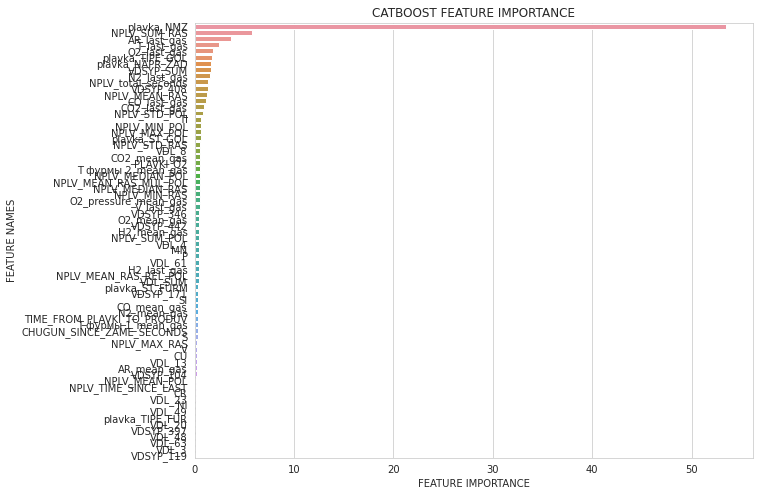

In [360]:
utils.plot_feature_importance(model_2.get_feature_importance(), used_features_2,'CATBOOST ')

## Predict

**Полное обучение моделей**

In [361]:
print('Model 1 iterations:', model_1.best_iteration_)
model_1_full = CatBoostRegressor(
    iterations=model_1.best_iteration_,
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_1,
)
model_1_full.fit(X_1, y_1);
y_test_pred_1_full = model_1_full.predict(X_test_1)

# full train
print('Model 2 iterations:', model_2.best_iteration_)
model_2_full = CatBoostRegressor(
    iterations=model_2.best_iteration_,
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_2,
)
model_2_full.fit(X_2, y_2);
y_test_pred_2_full = model_2_full.predict(X_test_2)

Model 1 iterations: 397
Model 2 iterations: 612


**Прогноз теста**

In [362]:
# predict
save_df = sub_df.copy()
save_df['TST'] = y_test_pred_1_full
save_df['C'] = y_test_pred_2_full
assert save_df.shape[0] == sub_df.shape[0]
save_df.to_csv('./results/submission_final.csv', index = False)
save_df.head(3)

,NPLV,TST,C
0,512324,1647.422989,0.037204
1,512327,1633.010953,0.073522
2,512328,1647.896242,0.095208
